Point by point stage movement using set position


In [1]:
from pipython2 import GCSDevice
from pipython2 import gcscommands
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import serial
import subprocess
import matplotlib
from tqdm import tqdm as tqdm

In [2]:
#create device object
gcs = GCSDevice('E-727')
print(gcs)

GCSCommands(msgs=GCSMessages(interface=GCSDll(C:\ProgramData\PI\GCSTranslator\PI_GCS2_DLL_x64.dll)), id=-1)


In [3]:
#gcs.InterfaceSetupDlg()

In [4]:
#connect Piezo stage (check COM number and baudrate from PI umove app)
gcs.ConnectRS232(3,460800)

In [5]:
#check connection status and set servo mode ON
#Correct value like  "(c)2015 Physik Instrumente (PI) GmbH & Co. KG, E-727, 0116008043, 13.21.00.08"
print (gcs.qIDN())
gcs.SVO1([1,2,3],[1,1,1])
print(gcs.qSVO1([1,2,3]))  #1 - ON, 0 - OFF. For this script all values should be ON

(c)2015 Physik Instrumente (PI) GmbH & Co. KG, E-727, 0116008043, 13.21.00.08

1=1 
2=1 
3=1



In [6]:
#open serial port for shutter control
shutter_port = 'COM9' # change this to where Arduino is connected. Check Device Manager -> Ports
shutter_serial = serial.Serial(shutter_port, 9600)
shutter_channel = 'A'

def shutter_open():
    shutter_serial.write("A0\n".encode('utf-8'))

def shutter_close():
    shutter_serial.write("A1\n".encode('utf-8'))

In [7]:
shutter_open()

In [8]:
shutter_close()

In [9]:
def run_spad(file_name, x, y, timestamps):
    subprocess.Popen([r"C:\Users\PREZES\Documents\stage-control\nanoSPAD.exe",
                   str(file_name),
                   str(x),
                   str(y),
                   str(timestamps),
                   "-t"])

In [10]:
import subprocess
import numpy as np

def photoncounting(int_time, file_name= r"C:\Users\PREZES\Documents\stage-control\SPAD_photocounting\results\temp", spad_file= r"C:\Users\PREZES\Documents\stage-control\SPAD_photocounting\nanoSPAD.exe"):
    '''The function runs the photon counting measurement i.e. saves the number of counts at each detector in the given time
    Args:
    int_time - The integration time of measurement (the duration of photoncounting measurement) in (10's of ns, not sure, Olek pleas check)
    file_name - The path to file where the photoncounting data will be saved as a binary file
    spad_file - The path to file with spad photoncounting program. (Rather don't change it)'''
    subprocess.run([spad_file,
                   "-t",
                   str(file_name),
                   str(0),
                   str(0),
                   str(int_time)])

def readPhotoncounts(file_name= r"C:\Users\PREZES\Documents\stage-control\SPAD_photocounting\results\temp"):
    '''The function reads the photoncounting data and returns the vector of total counts at each SPAD pixel during the measurement
    Args:
    file_name - The path to file where the photoncounting data was saved as a binary file'''
    
    d=np.fromfile(file_name,dtype =np.uint8)
    d=d.reshape(np.shape(d)[0]//4,4)
    d=np.uint64(d)
    d[:,1]=d[:,1]*(2**8)
    d[:,2]=d[:,2]*(2**16)
    d[:,3]=d[:,3]*(2**24)
    I=(d.sum(axis=1))
    return I

In [11]:
def plot_chip(I):
    M=np.zeros((500,500))
    k=0
    for j in range(5):
        for i in range(5):
            if j%2==0:
                M[100*j:100*j+99,100*i:100*i+99]=I[k]
                k+=1
            else:
                M[100*j:100*j+99,50+100*i:50+100*i+99]=I[k]
                k+=1
                if i==3:
                    break
    return M
    

In [12]:
#used basic functions defined here: C:\Anaconda3\Lib\site-packages\PIPython-1.3.9.40-py3.7.egg\pipython\gcscommands.py

def point_by_point_snake_3(gcs,y_points,x_points,dwell_time,
                       delta_dist,offset,rep = 10 ,velocity=50):
    """
        V3 using trigger mode 2
        Move stage in 2D on rectangular area and stop on every point for set dwell time.
        Trigger on selected channel send signal when stage is on target
        Parameters:
        gcs : piezo stage object
        x_points,y_points : Number of measuring points in both axis (int, minimum 2)
        dwell_time : stop time for one point in seconds (float, minimum 0.01s)
        delta_dist : distance between two neighbor points in micrometers (float, minimum 0.01um)
        offset : start position of the stage ([float,float,float], range[0,200])
       velocity: velocity of the stage
       
       Output  is +-2% of registered time and may depend on velocity
    """
    dwell_time = dwell_time*1.0/1000.
    wait_time =dwell_time +delta_dist*1.0/(velocity*1.2)+0.015
    print("wait time set as ",wait_time)
    gcs.VEL1([1,2,3],[10000,10000,10000])
    gcs.MOV1([1,2,3],[offset[0]-delta_dist,offset[1],offset[2]-delta_dist])
    input('Press enter to start')
    gcs.VEL1([1,2,3],[velocity,velocity,velocity])
    start =time.time()
    gcs.CTO1(1,[2,3],[1,2])
    gcs.CTO1(2,[2,3],[2,2])
    gcs.CTO1(3,[2,3],[3,2])

    t1=time.time()
    print(0,0,t1-start)
    tnow= time.time()
    for a in range(rep):
        try:
            #Move to initial point
            gcs.MOV1([1,2,3],offset)
            t1=time.time()
            while (time.time()-t1<wait_time):
                continue
            tnow=time.time() 
            print(0,0,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
            for i in range(int(x_points/2)):
                
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1),offset[2]])

                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    #print(2*i,j+1)
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(j+1),offset[2]])
                t1=time.time()
                while (time.time()-t1<wait_time):
                    continue
                tnow=time.time() 
                #print(2*i+1,j+1)
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-j-2),offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time() 
                    #print(2*i+1,y_points-j-2)
                if i <int(x_points/2)-1:
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+2),offset[1],offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    #print(2*i+2,0)
        except KeyboardInterrupt:
            break
    gcs.MOV1([1,2,3],[offset[0],offset[1],offset[2]])
    print("finished stage scan, duration: ",time.time()-start)  
    
def point_by_point_snake_4(gcs,y_points,x_points,dwell_time,
                       delta_dist,offset,rep = 10 ,velocity=50):
    """
        V3 using trigger mode 2
        Move stage in 2D on rectangular area and stop on every point for set dwell time.
        Trigger on selected channel send signal when stage is on target
        Parameters:
        gcs : piezo stage object
        x_points,y_points : Number of measuring points in both axis (int, minimum 2)
        dwell_time : stop time for one point in seconds (float, minimum 0.01s)
        delta_dist : distance between two neighbor points in micrometers (float, minimum 0.01um)
        offset : start position of the stage ([float,float,float], range[0,200])
       velocity: velocity of the stage
       
       Output  is +-2% of registered time and may depend on velocity
    """
    dwell_time = dwell_time*1.0/1000.
    wait_time =dwell_time +delta_dist*1.0/(velocity*1.2)+0.015
    print("wait time set as ",wait_time)
    gcs.VEL1([1,2,3],[10000,10000,10000])
    gcs.MOV1([1,2,3],[offset[0]-delta_dist,offset[1],offset[2]-delta_dist])
    #input('Press enter to start')
    gcs.VEL1([1,2,3],[velocity,velocity,velocity])
    start =time.time()
    gcs.CTO1(1,[2,3],[1,2])
    gcs.CTO1(2,[2,3],[2,2])
    gcs.CTO1(3,[2,3],[3,2])

    t1=time.time()
    print(0,0,t1-start)
    tnow= time.time()
    for a in range(rep):
        try:
            #Move to initial point
            gcs.MOV1([1,2,3],offset)
            t1=time.time()
            while (time.time()-t1<wait_time):
                continue
            tnow=time.time() 
            print(0,0,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
            for i in tqdm(range(int(x_points/2))):
                
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1),offset[2]])

                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    #print(2*i,j+1)
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(j+1),offset[2]])
                t1=time.time()
                while (time.time()-t1<wait_time):
                    continue
                tnow=time.time() 
                #print(2*i+1,j+1)
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-j-2),offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time() 
                    #print(2*i+1,y_points-j-2)
                if i <int(x_points/2)-1:
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+2),offset[1],offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    #print(2*i+2,0)
        except KeyboardInterrupt:
            break
    gcs.MOV1([1,2,3],[offset[0],offset[1],offset[2]])
    print("finished stage scan, duration: ",time.time()-start)                       
        
def move_to_point(gcs, offset, trigger_channel = 1):
    """
        Move stage command to selected position in 3D and trigger signal after arrival  
        gcs : piezo stage object

        offset : start position of the stage ([float,float,float], range[0,200])
        trigger_channel : output trigger channel (int, in [1,2,3])
    """    
    if max(offset)>200 or min(offset)<0:
        print('Set correct position between(0,200)')
    else:
        gcs.VEL1([1,2,3],[10000,10000,10000])    
        gcs.CTO1(trigger_channel,[2,3],[1,2])
        gcs.MOV1([1,2,3],offset)
        
def set_trigger_params(trigger_output,window_range=0.015,time_range=0.01):
    """
    Set in memory parameters of on-target status parameters
    trigger output :number of output channel (1,2,3)
    window_range: distance between real value and target in which stage send high value in micrometer
    time range: time for how long stage is in range to send a high value in seconds
    """
    gcs.SPA1(trigger_output,'0x07000900',window_range )
    gcs.SPA1(trigger_output,'0x07000901',time_range )   


In [13]:
# Set on-target status parameters for all axes

gcs.CCL1(1,'advanced')
set_trigger_params(1,0.025,0.01)
set_trigger_params(2,0.025,0.01)
set_trigger_params(3,0.025,0.01)

In [17]:
#START SCAN
# Process:
#0) choose file name for saving
#1) nanoSPAD_X/Y: number of scan points in X and Y
#2) dwell_time: [ms]
#3) delta_dist: scan step [um]
#4) offset: starting point [um]
#5) Run this cells

data_file=r"C:\Users\PREZES\Documents\stage-control\data\NANOspad\2021.06\skylan_astro_test_20x20_dwell50.spad"
log_file=data_file.replace(".spad", ".txt")

nanoSPAD_X=20
nanoSPAD_Y=20
dwell_time = 50
delta_dist = 0.5
offset = [119,133,100.277]
velocity=50
p=1.6
np.savetxt(log_file, [nanoSPAD_X, nanoSPAD_Y,dwell_time,delta_dist,offset[0], offset[1], offset[2],p], fmt='%.3f')

timestamping_duration=int(nanoSPAD_X*nanoSPAD_Y*dwell_time*p*100)+75000
#timestamping_duration=700000000

run_spad(data_file, x=1, y=1, timestamps=timestamping_duration)
shutter_open() #open shutter
time.sleep(0.75) #estimated duration of opening of the shutter
point_by_point_snake_4(gcs, nanoSPAD_X, nanoSPAD_Y, dwell_time, delta_dist, offset, 1, velocity)
shutter_close() #close shutter



  0%|                                                   | 0/10 [00:00<?, ?it/s]

wait time set as  0.07333333333333333
0 0 0.011999845504760742
0 0 0.08999967575073242 0.0 0.04


100%|██████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]

finished stage scan, duration:  31.55999994277954


In [56]:
nanoSPAD_X=5
nanoSPAD_Y=6
dwell_time = 200
delta_dist = 0.05
offset = [118.948,164.443,99.723]
velocity=50
p=1.05

timestamping_duration=int(nanoSPAD_X*nanoSPAD_Y*dwell_time*p*100)+75

In [61]:
timestamping_duration-75000

689999

In [17]:
plt.plot(np.arange(5))

In [246]:
%matplotlib qt
from matplotlib.widgets import Button
from matplotlib.widgets import CheckButtons

In [71]:
flag=Flag()

In [76]:
flag.f

True

In [73]:
flag.stop()

In [108]:
I[0]

35

In [269]:
%matplotlib qt

I = readPhotoncounts()
int_time=0.005
class Controlers(object):
    f = True
    ymin=0
    ymax=0
    def stop(self, event):
        self.f=False
    def rescale(self,I):
        self.ymin=np.min(I)#-0.05*(np.max(I)-np.min(I))
        self.ymax=np.max(I)#+0.05*(np.max(I)-np.min(I))
        
        
# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
I=I/int_time
line1 =ax.imshow(plot_chip(I)) # Returns a tuple of line objects, thus the comma
bar=fig.colorbar(line1)

C=Controlers()
while C.f:
    photoncounting(int(int_time*10e8))
    I=readPhotoncounts()
    C.rescale(I)
    M=plot_chip(I)
    line1.set_data(M)
    norm=matplotlib.colors.Normalize(vmin=C.ymin, vmax=C.ymax)
    line1.set_norm(norm)
    cbar_ticks = np.linspace(C.ymin, C.ymax, num=10)
    bar.set_ticks(cbar_ticks)
    fig.canvas.draw()
    fig.canvas.flush_events()
    axbreak = plt.axes([0.05, 0.2, 0.1, 0.075])
    axascale = plt.axes([0.005, 0.8, 0.2, 0.2])
    bnbreak = Button(axbreak, 'Break')
    ascale=CheckButtons(axascale,labels=["Auto scale"])
    ascale.on_clicked(C.rescale(I))
    bnbreak.on_clicked(C.stop)
%matplotlib inline

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\matplotlib\widgets.py", line 613, in _c

In [239]:
norm



In [201]:
C.ymin

0

In [202]:
line1


In [138]:
plt.imshow(M)
plt.colorbar()

In [116]:
%matplotlib qt
x = np.arange(23)
y = readPhotoncounts()

class Controlers(object):
    f = True
    ymin=0
    ymax=0
    def stop(self, event):
        self.f=False
    def rescale(self,I):
        self.ymin=np.min(I)-0.05*(np.max(I)-np.min(I))
        self.ymax=np.max(I)+0.05*(np.max(I)-np.min(I))
        
        
# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'ro') # Returns a tuple of line objects, thus the comma
C=Controlers()
while C.f:
    photoncounting(int(0.005*100000000))
    I=readPhotoncounts()
    C.rescale(I)
    ax.set_ylim([C.ymin,C.ymax])
    line1.set_ydata(I)
    fig.canvas.draw()
    fig.canvas.flush_events()
    axbreak = plt.axes([0.81, 0.01, 0.1, 0.075])
    bnbreak = Button(axbreak, 'Break')
    bnbreak.on_clicked(C.stop)
%matplotlib inline

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


SyntaxError: 'break' outside loop (<ipython-input-31-5d29d6bbce00>, line 5)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [18]:

x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for phase in np.linspace(0, 10*np.pi, 500):
    line1.set_ydata(np.sin(x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [3]:
import tkinter as tk
from tkinter import Button
import numpy as np
import matplotlib
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

matplotlib.use('TkAgg')

def displ_graf(datalst):
    ff = plt.figure(figsize=(5.6,4), dpi=100)
    xx = ff.add_subplot(1,1,1)
    nn = np.arange(len(datalst))
    bb = xx.barh(nn, datalst, 0.8)
    ff.tight_layout
    cc = FigureCanvasTkAgg(ff, master=ww)
    cc.draw()
    cc.get_tk_widget().pack(side=tk.RIGHT)

def graf2():
    plt.close('all')
    data2 = [64, 58, 12, 91, 49, 32, 70, 23, 35]
    displ_graf(data2)



In [4]:
ww = tk.Tk()
ww.geometry('700x400')
ww.state('zoomed')
butt3 = Button(ww,text=' CHANGE DATA ',command=graf2, height=1,width=15)
butt3.place(x=790, y=100)

data1 = [31, 41, 59, 26, 53, 58, 97, 93, 23]
displ_graf(data1)
ww.mainloop()

In [3]:
ww = tk.Tk()
ww.geometry('700x400')
ww.state('zoomed')
#butt3 = Button(ww,text=' CHANGE DATA ',command=graf2, height=1,width=15)
#butt3.place(x=790, y=100)
graf2()


In [1]:
graf2()

NameError: name 'graf2' is not defined

In [5]:
fig, ax = plt.subplots()
ln, = ax.plot(I,'o')
ln.set_color('orange')


NameError: name 'I' is not defined

In [211]:
ln, = ax.plot(range(5))

In [212]:
ln.set_color('orange')

In [213]:
fig.plot(I)

AttributeError: 'Figure' object has no attribute 'plot'

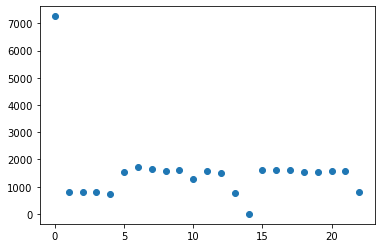

In [184]:
plt.plot(d.sum(axis=0),'o')

In [119]:
d=np.fromfile('.\SPAD_photocounting\QOLcounts4',dtype =np.uint8)
d=d.reshape(4,np.shape(d)[0]//4)
d[3,3]

2

In [133]:
d=np.fromfile('.\SPAD_photocounting\QOLcounts4',dtype =np.uint8)
d=d.reshape(4,np.shape(d)[0]//4)
d=np.uint64(d)
d[1,:]=d[1,:]*(2**8)
d[2,:]=d[2,:]*(2**16)
d[3,:]=d[3,:]*(2**24)
d[3,3]

33554432

In [160]:
photoncounting(100000)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]], dtype=uint8)

In [58]:
(timestamping_duration-75000)/100000


5.55075

In [18]:
move_to_point(gcs,[42.666,98.461,106.195])

In [22]:
shutter_serial.close()

In [21]:
gcs.CloseConnection()

In [10]:
vel =0.1*1e6/(2*50)
gcs.VEL1([1,2,3],[vel,vel,vel])

In [11]:
def point_by_point_snake(gcs,x_points,y_points,dwell_time,
                       delta_dist,offset,rep = 10 ,trigger_channel = 1):
    """
        Move stage in 2D on rectangular area and stop on every point for set dwell time.
        Trigger on selected channel send signal when stage is on target
        Parameters:
        gcs : piezo stage object
        x_points,y_points : Number of measuring points in both axis (int, minimum 2)
        dwell_time : stop time for one point in seconds (float, minimum 0.01s)
        delta_dist : distance between two neighbor points in micrometers (float, minimum 0.01um)
        offset : start position of the stage ([float,float,float], range[0,200])
        rep : number of cycles of the movement (int, 0 means infinity, )
        trigger_channel : output trigger channel (int, in [1,2,3])
    """
    
    gcs.CTO1(trigger_channel,[2,3],[1,2])
    gcs.MOV1([1,2,3],offset)
    time.sleep(max(dwell_time-0.01,0))
    gcs.CTO1(trigger_channel,[2,3],[1,2])
    print(0,0)
    x_pos=np.arange(offset[0],x_points*delta_dist,delta_dist)
    y_pos=np.arange(offset[1],y_points*delta_dist,delta_dist)
    for a in range(rep):
        try:
            for i in range(int(x_points/2)):
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1),offset[2]])
                    time.sleep(max(dwell_time-0.01,0))
                    gcs.CTO1(trigger_channel,[2,3],[1,2])
                    print(2*i,j+1)
                gcs.CTO1(trigger_channel,[2,3],[2,2])
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(j+1),offset[2]])
                time.sleep(max(dwell_time-0.01,0))
                gcs.CTO1(trigger_channel,[2,3],[1,2])
                print((2*i+1),j+1)
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-j-2),offset[2]])
                    time.sleep(max(dwell_time-0.01,0))
                    gcs.CTO1(trigger_channel,[2,3],[1,2])    
                    print(2*i+1,y_points-j-2)
                gcs.CTO1(trigger_channel,[2,3],[1,2])
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+2),offset[1],offset[2]])
                time.sleep(max(dwell_time-0.01,0))
                gcs.CTO1(trigger_channel,[2,3],[1,2])
                print(2*i+2,0)
        except KeyboardInterrupt:
            break

##Correctting


In [8]:
def point_by_point_snake_2(gcs,x_points,y_points,dwell_time,
                       delta_dist,offset,rep = 10):
    """
        V1: Using trigger mode 0
        Move stage in 2D on rectangular area and stop on every point for set dwell time.
        Trigger signals reresent new point/line/frame(channels 1/2/3  respectively)
        
        Parameters:
        gcs : piezo stage object
        x_points,y_points : Number of measuring points in both axis (int, minimum 2)
        dwell_time : stop time for one point in seconds (float, minimum 0.01s)
        delta_dist : distance between two neighbor points in micrometers (float, minimum 0.01um)
        offset : start position of the stage ([float,float,float], range[0,200])
        rep : number of cycles of the movement (int)
    """
    #Important parameters
    half = dwell_time *1/2
    #Setting velocity of the piezo (required to be low enough for trigger step size)
    vel =delta_dist*1e6/(25)
    gcs.VEL1([1,2,3],[vel,vel,vel])
    #Snake start 
    start =time.time()
    #Set in point nerby starting position(for trigger)
    gcs.MOV1([1,2,3],[offset[0]-delta_dist/4.,offset[1]-delta_dist/4.,offset[2]--delta_dist/4.])
    #Set triggers
    gcs.CTO1(1,[2,3,1],[1,0,delta_dist])
    gcs.CTO1(2,[2,3,1],[2,0,delta_dist])
    gcs.CTO1(3,[2,3,1],[3,0,delta_dist])

    gcs.MOV1([1,2,3],[offset[0]-delta_dist/2.,offset[1]-delta_dist/2.,offset[2]-delta_dist/4.])
    t1=time.time()
    while (time.time()-t1<0.01):
        continue 
    for a in range(rep):
        try:
            #Move to initial point
            gcs.MOV1([1,2,3],offset)
            t1=time.time()
            while (time.time()-t1<dwell_time):
                continue
            tnow=time.time()
            #move to point between in purpose of trigger mode and stay for 10ms
            gcs.MOV1([1,2,3],[offset[0],offset[1]+half,offset[2]])
            t1=time.time()
            while (time.time()-t1<0.01):
                continue           
            for i in range(int(x_points/2)):
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1),offset[2]])
                    t1=time.time()
                    while (time.time()-t1<dwell_time):
                        continue                   
                    print(2*i,j+1,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
                    tnow= time.time()
                    if j!=y_points-2:
                        
                        gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1)+half,offset[2]])
                        t1=time.time()
                        while (time.time()-t1<0.01):
                            continue 
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i+half,offset[1]+delta_dist*(y_points-1)+half,offset[2]])
                t1=time.time()
                while (time.time()-t1<0.01):
                    continue                             
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-1),offset[2]])
                t1=time.time()
                while (time.time()-t1<dwell_time):
                    continue  
                print((2*i+1),j+1,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
                tnow= time.time()
                
                
                for j in range(int(y_points)-1):
                    
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-j-2),offset[2]])
                    t1=time.time()
                    while (time.time()-t1<dwell_time):
                        continue                  
                    print(2*i+1,y_points-j-2,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
                    tnow= time.time()
                    if j!=y_points-2:
                        
                        gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(j+1)-half,offset[2]])
                        t1=time.time()
                        while (time.time()-t1<0.01):
                            continue

                if i==int(x_points/2)-1:
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i+half,offset[1]+delta_dist*(y_points-1)-half,offset[2]])
                    t1=time.time()
                    while (time.time()-t1<0.01):
                        continue
                        
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+2),offset[1],offset[2]])
                    t1=time.time()
                    
                    while (time.time()-t1<dwell_time):
                        continue  
                    print((2*i+1),j+1,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
                    tnow= time.time()
                else:
                    gcs.MOV1([1,2,3],[offset[0]-half,offset[1]-half,offset[2]-half])
                    t1=time.time()
                    while (time.time()-t1<0.01):
                        continue 
        except KeyboardInterrupt:
            break

def point_by_point_snake_3(gcs,y_points,x_points,dwell_time,
                       delta_dist,offset,rep = 10 ,velocity=50):
    """
        V3 using trigger mode 2
        Move stage in 2D on rectangular area and stop on every point for set dwell time.
        Trigger on selected channel send signal when stage is on target
        Parameters:
        gcs : piezo stage object
        x_points,y_points : Number of measuring points in both axis (int, minimum 2)
        dwell_time : stop time for one point in seconds (float, minimum 0.01s)
        delta_dist : distance between two neighbor points in micrometers (float, minimum 0.01um)
        offset : start position of the stage ([float,float,float], range[0,200])
       velocity: velocity of the stage
       
       Output  is +-2% of registered time and may depend on velocity
    """
    wait_time =dwell_time +delta_dist*1.0/(velocity*1.2)+0.015
    print(wait_time)
    gcs.VEL1([1,2,3],[10000,10000,10000])
    gcs.MOV1([1,2,3],[offset[0]-delta_dist,offset[1],offset[2]-delta_dist])
    input('Press enter to start')
    gcs.VEL1([1,2,3],[velocity,velocity,velocity])
    start =time.time()
    gcs.CTO1(1,[2,3],[1,2])
    gcs.CTO1(2,[2,3],[2,2])
    gcs.CTO1(3,[2,3],[3,2])

    t1=time.time()
    print(0,0,t1-start)
    tnow= time.time()
    for a in range(rep):
        try:
            #Move to initial point
            gcs.MOV1([1,2,3],offset)
            t1=time.time()
            while (time.time()-t1<wait_time):
                continue
            tnow=time.time() 
            print(0,0,time.time()-start,time.time()-tnow,max(dwell_time-0.01,0))
            for i in range(int(x_points/2)):
                
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*2*i,offset[1]+delta_dist*(j+1),offset[2]])

                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    print(2*i,j+1)
                gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(j+1),offset[2]])
                t1=time.time()
                while (time.time()-t1<wait_time):
                    continue
                tnow=time.time() 
                print(2*i+1,j+1)
                for j in range(int(y_points)-1):
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+1),offset[1]+delta_dist*(y_points-j-2),offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time() 
                    print(2*i+1,y_points-j-2)
                if i <int(x_points/2)-1:
                    gcs.MOV1([1,2,3],[offset[0]+delta_dist*(2*i+2),offset[1],offset[2]])
                    t1=time.time()
                    while (time.time()-t1<wait_time):
                        continue
                    tnow=time.time()
                    print(2*i+2,0)
        except KeyboardInterrupt:
            break
    gcs.MOV1([1,2,3],[offset[0]+delta_dist,offset[1]+delta_dist*y_points,offset[2]])
                        
        